In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib import cm
from mpl_toolkits import mplot3d

## Auxiliary functions

These functions are used in the next sections to plot the figures.

These figures are a grid approximation estimation of the different distributions involved in a hierarchical model for the single coin from a single mint example.

The prior distribution is calculated as:

$p(\theta, \omega) = p(\theta|\omega)p(\omega)$

The likelihood distribution is calculated as:

$p(D|\theta, \omega) = \theta^{z}(1 - \theta)^{n-z}$

And the posterior distribution $p(\theta, \omega | D))$ is calculated by multiplying each cell of the prior grid by each corresponding cell in the likelihood grid and then normalising.

Both prior and posterior are normalised and then each cell is divided by the cell area to transform probability masses into probability densities.

In [2]:
# This function calculates the prior, likelihood and posterior distributions from the selected parameters
#
# The parameters parameter is a dictionary with the following fields:
#   - a_w: alpha parameter for omega's beta distribution
#   - b_w: beta parameter for omega's beta distribution
#   - k: k parameter for theta's beta distribution
#   - n: number of observed coin flips
#   - z: number of observed heads
def calculate_pdfs(paremeters, granularity = 100):
    theta = np.linspace(0, 1, granularity)
    omega = np.linspace(0, 1, granularity)
    width_t = theta[1]
    width_w = omega[1]
    THETA, OMEGA = np.meshgrid(theta, omega)
    prior = np.multiply(beta.pdf(THETA, 
                                 OMEGA * (parameters['k'] - 2) + 1, 
                                 (1 - OMEGA) * (parameters['k'] - 2) + 1), 
                        beta.pdf(OMEGA, parameters['a_w'], parameters['b_w']))
    prior = prior / (np.sum(np.sum(prior)) * width_t * width_w)
    likelihood = np.multiply(np.power(THETA, parameters['z']), np.power(1 - THETA, parameters['n'] - parameters['z']))
    posterior = np.multiply(prior, likelihood) 
    posterior = posterior / (np.sum(np.sum(posterior)) * width_t * width_w)
    
    return theta, omega, prior, likelihood, posterior

In [3]:
# Plots the top or bottom section of the figure, i.e. the prior and the posterior sections
# The pdf parameter is either the prior or the posterior calculated by the function above
# If parameters is assigned the parameters dictionary, the function will be assuming that it is plotting
# the top section (prior) and will adapt the label accordingly
def plot_prior_posterior(pdf, theta, omega, parameters = None):
    width_t = theta[1]
    THETA, OMEGA = np.meshgrid(theta, omega)
    marginal_theta = np.sum(pdf, axis = 0) / pdf.shape[1]
    marginal_omega = np.sum(pdf, axis = 1) / pdf.shape[0]
    marginal_theta_w_075 = pdf[75, :] / (np.sum(pdf[75, :]) * width_t)
    marginal_theta_w_025 = pdf[25, :] / (np.sum(pdf[25, :]) * width_t)
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(4, 3)
    ax1 = fig.add_subplot(gs[0:2, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, pdf, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('prior')

    ax2 = fig.add_subplot(gs[0:2, 1])
    ax2.contourf(THETA, OMEGA, pdf, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[0:2, 2])
    ax3.plot(marginal_omega, omega)
    ax3.set_xlabel(r'Marginal $p(\omega)$')
    ax3.set_ylabel(r'$\omega$')

    ax4 = fig.add_subplot(gs[2:4, 0])
    ax4.axis('off')
    if parameters is not None:
        parameters_str = '$A_{\omega}$ = ' + \
                         str(parameters['a_w']) + \
                         ', $B_{\omega}$ = ' + \
                         str(parameters['b_w']) + \
                         '\nK = ' + \
                         str(parameters['k'])
        ax4.text(1.1, 0.65, 'Prior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')
        ax4.text(1.1, 0.4, parameters_str, transform = ax4.transAxes, fontsize = 12, horizontalalignment = 'right')
    else:
        ax4.text(1.1, 0.65, 'Posterior', transform = ax4.transAxes, fontsize = 18, horizontalalignment = 'right')

    ax5 = fig.add_subplot(gs[2:4, 1])
    ax5.plot(theta, marginal_theta)
    ax5.set_xlabel(r'$\theta$')
    ax5.set_ylabel(r'Marginal $p(\theta)$')

    ax6 = fig.add_subplot(gs[2, 2])
    ax6.plot(theta, marginal_theta_w_075)
    ax6.set_xlabel(r'$\theta$')
    ax6.set_ylabel(r'$p(\theta|\omega=.75)$')

    ax7 = fig.add_subplot(gs[3, 2])
    ax7.plot(theta, marginal_theta_w_025)
    ax7.set_xlabel(r'$\theta$')
    ax7.set_ylabel(r'$p(\theta|\omega=.25)$')

    fig.set_figwidth(8)
    fig.set_figheight(5)
    plt.tight_layout()
    
    return [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

In [4]:
# Plots the medium section of the figure (likelihood)
def plot_likelihood(likelihood, theta, omega, parameters):
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(2, 3)
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax1.plot_surface(THETA, OMEGA, likelihood, cmap = cm.coolwarm, edgecolor = 'none')
    ax1.view_init(30, 250)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.xaxis.labelpad = -15
    ax1.yaxis.labelpad = -15
    ax1.zaxis.labelpad = -15
    ax1.set_xlabel('theta')
    ax1.set_ylabel('omega')
    ax1.set_zlabel('likelihood')

    ax2 = fig.add_subplot(gs[:, 1])
    ax2.contourf(THETA, OMEGA, likelihood, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[:, 2])
    ax3.axis('off')
    data_str = 'D = ' + str(parameters['z']) + ' heads, ' + str(parameters['n'] - parameters['z']) + ' tails'
    ax3.text(0, 0.55, 'Likelihood', transform = ax3.transAxes, fontsize = 18, horizontalalignment = 'left')
    ax3.text(0, 0.4, data_str, transform = ax3.transAxes, fontsize = 12, horizontalalignment = 'left')

    fig.set_figwidth(8)
    fig.set_figheight(2.5)
    plt.tight_layout()

In [5]:
# Plots the complete figure given a set of parameters (see the definition of the
# calculate_pdfs function for a description of this parameter)
def plot_figure(parameters):
    theta, omega, prior, likelihood, posterior =  calculate_pdfs(parameters)

    axes_prior = plot_prior_posterior(prior, theta, omega, parameters)
    plot_likelihood(likelihood, theta, omega, parameters)
    axes_posterior = plot_prior_posterior(posterior, theta, omega)

    max_marginal_w = max(axes_prior[2].get_xlim()[1], axes_posterior[2].get_xlim()[1])
    max_marginal_theta = max(axes_prior[4].get_ylim()[1], axes_posterior[4].get_ylim()[1])
    axes_prior[2].set_xlim([0, max_marginal_w])
    axes_posterior[2].set_xlim([0, max_marginal_w])
    axes_prior[4].set_ylim([0, max_marginal_theta])
    axes_posterior[4].set_ylim([0, max_marginal_theta])

    max_marginal_075 = max(axes_prior[5].get_ylim()[1], axes_posterior[5].get_ylim()[1])
    max_marginal_025 = max(axes_prior[6].get_ylim()[1], axes_posterior[6].get_ylim()[1])
    axes_prior[5].set_ylim([0, max_marginal_075])
    axes_posterior[5].set_ylim([0, max_marginal_075])
    axes_prior[6].set_ylim([0, max_marginal_025])
    axes_posterior[6].set_ylim([0, max_marginal_025])

## Figures

**Figure 9.2** The prior has low certainty regarding $\omega$, but high certainty regarding the dependence of $\theta$ on $\omega$. The posterior shows that the distribution of $\omega$ has been altered noticeably by the data (see sideways plots of marginal $p(\omega)$), but the dependence of $\theta$ on $\omega$ has not been altered much (see small plots of $p(\theta|\omega)$). Compare with Figure 9.3, which uses the same data but a different prior. 

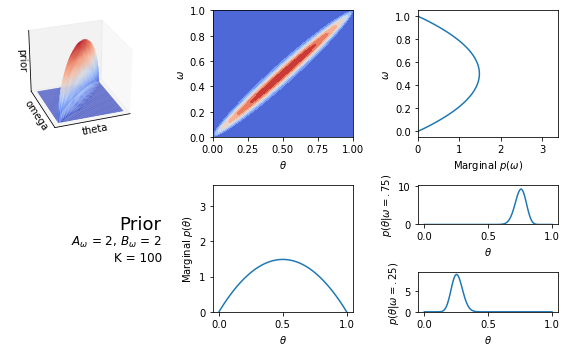

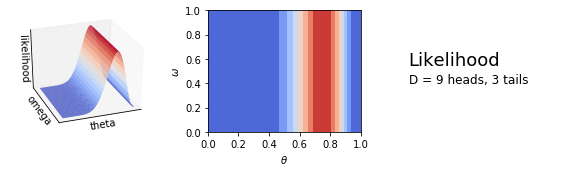

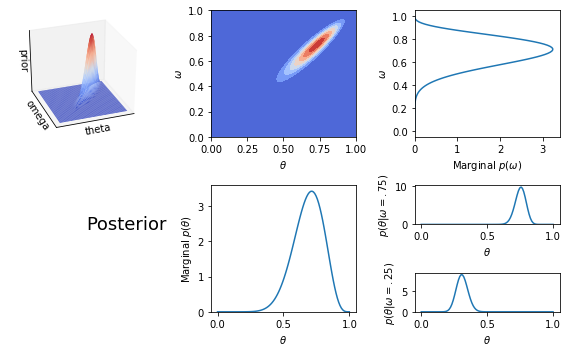

In [6]:
parameters = {
    'a_w': 2,
    'b_w': 2,
    'k': 100,
    'n': 12, 
    'z': 9
}

plot_figure(parameters)

**Figure 9.3** The prior has high certainty regarding $\omega$, but low certainty regarding the dependence of $\theta$ on $\omega$. The posterior shows that the distribution of $\omega$ has not been altered much by the data (see sideways plots of marginal $p(\omega)$), but the dependence of $\theta$ on $\omega$ has been altered noticeably (see small $p(\theta|\omega)$). Compare with Figure 9.2, which uses the same data but a different prior.

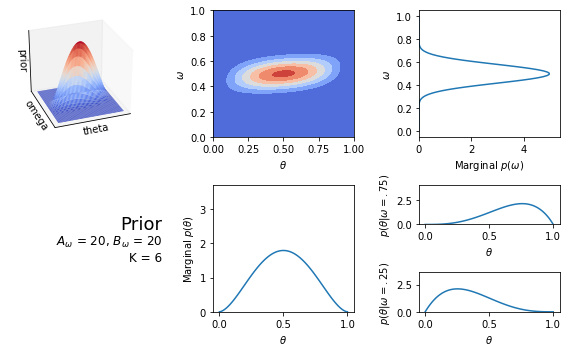

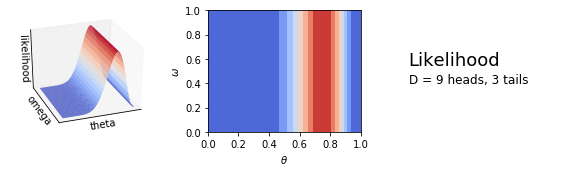

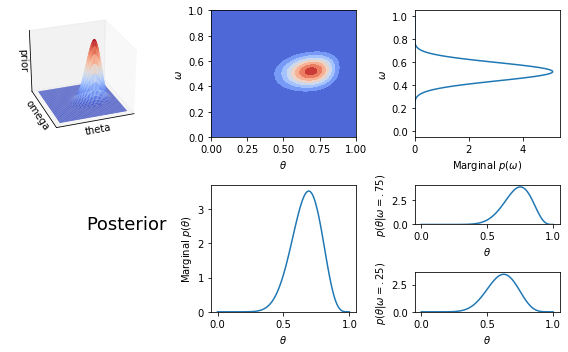

In [7]:
parameters = {
    'a_w': 20,
    'b_w': 20,
    'k': 6,
    'n': 12, 
    'z': 9
}

plot_figure(parameters)